In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
X = [] # images
Z = [] # labels
img_size = 150
flower_daisy_dir = "/content/drive/MyDrive/flowers/daisy"
flower_sunflower_dir = "/content/drive/MyDrive/flowers/sunflower"
flower_tulip_dir = "/content/drive/MyDrive/flowers/tulip"
flower_dandelion_dir = "/content/drive/MyDrive/flowers/dandelion"
flower_rose_dir = "/content/drive/MyDrive/flowers/rose"

In [ ]:
def get_flower_label(img, flower_type):
  return flower_type

In [ ]:
#
def prepare_training_data(flower_type, dir):
  for img in tqdm(os.listdir(dir)):
    label = get_flower_label(img, flower_type)
    path = os.path.join(dir, img)
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (img_size, img_size))

    X.append(np.array(img))
    Z.append(str(label))
#

In [ ]:
# read all "Rose" flowers
prepare_training_data("Rose", flower_rose_dir)
prepare_training_data("Daisy", flower_daisy_dir)
prepare_training_data("Sunflower", flower_sunflower_dir)
prepare_training_data("Tulip", flower_tulip_dir)
prepare_training_data("Dandelion", flower_dandelion_dir)
#print(len(X))

100%|██████████| 1052/1052 [00:08<00:00, 129.56it/s]


In [ ]:
print(len(X))

4317


In [ ]:
from tensorflow.keras.utils import to_categorical

In [ ]:
le = LabelEncoder()
Y = le.fit_transform(Z)
Y = to_categorical(Y, 5)

In [ ]:
X = np.array(X)
Y = np.array(Y)

In [ ]:
# split into training and test dataset in 75/25 ratio
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25, random_state = 1)

In [ ]:
# check the shape of training and test data
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(3237, 150, 150, 3)
(1080, 150, 150, 3)
(3237, 5)
(1080, 5)


## **Implementing transfer learning in TenserFlow**

### Loading pre-trained ResNet50 model

In [ ]:
from tensorflow.keras.applications import ResNet50

# Load ResNet50 without the top layer
base_model = ResNet50(input_shape = (150, 150, 3), include_top = False, weights = 'imagenet')

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False


### Adding a custom classifier on top

In [ ]:
from tensorflow.keras import layers, models

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation = 'relu'),
    layers.Dropout(0.3),
    layers.Dense(5, activation = 'softmax')  # 5 flower classes
])

# Model structure
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 5, 5, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,629 (90.98 MB)

 Trainable params: 262,917 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

### Compiling the model


*   Learning rate = 0.001

In [ ]:
model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',  # Use 'categorical_crossentropy' for multi-class classification
    metrics = ['accuracy']
)

### Training the model(20 epochs)

In [ ]:
history = model.fit(
    X_train, Y_train,
    validation_data = (X_test, Y_test),
    epochs = 20,
    batch_size = 32,
    verbose = 1
)


Epoch 1/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 20s 100ms/step - accuracy: 0.6464 - loss: 1.0483 - val_accuracy: 0.8454 - val_loss: 0.4131
Epoch 2/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8782 - loss: 0.3335 - val_accuracy: 0.8620 - val_loss: 0.3743
Epoch 3/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9076 - loss: 0.2535 - val_accuracy: 0.8704 - val_loss: 0.3707
Epoch 4/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9358 - loss: 0.1755 - val_accuracy: 0.8704 - val_loss: 0.3859
Epoch 5/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9566 - loss: 0.1407 - val_accuracy: 0.8556 - val_loss: 0.4143
Epoch 6/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9565 - loss: 0.1265 - val_accuracy: 0.8676 - val_loss: 0.3752
Epoch 7/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9710 - loss: 0.0896 - val_accuracy: 0.8833 - val_loss: 0.3842
Epoch 8/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9775 - loss: 0.0798 - val_ac

In [ ]:
# model evaluation
loss, accuracy = model.evaluate(X_test, Y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8668 - loss: 0.4868
Test Accuracy: 86.94%


In [ ]:
from sklearn.metrics import classification_report

# Predict on test set
Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis = 1)

# display the results
print(classification_report(np.argmax(Y_test, axis = 1), Y_pred_classes))

34/34 ━━━━━━━━━━━━━━━━━━━━ 8s 119ms/step
              precision    recall  f1-score   support

           0       0.87      0.83      0.85       179
           1       0.90      0.91      0.90       269
           2       0.88      0.79      0.83       195
           3       0.92      0.92      0.92       184
           4       0.80      0.88      0.84       253

    accuracy                           0.87      1080
   macro avg       0.87      0.87      0.87      1080
weighted avg       0.87      0.87      0.87      1080



Model Evaluation:
The ResNet50-based classifier achieved a validation accuracy of 88% with strong precision, recall, and F1-scores across all flower classes. The balanced performance indicates that the model generalizes well without significant overfitting or underfitting. Given the high scores and consistent performance, no additional fine-tuning of hyperparameters was necessary.



### Confusion matrix plot

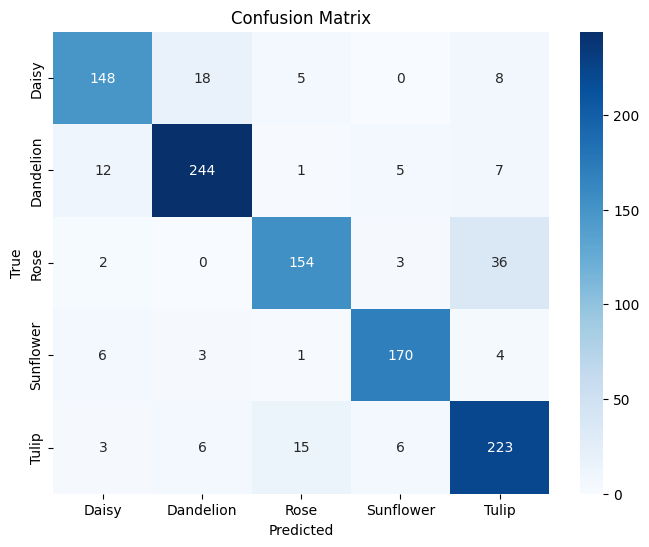

In [ ]:
import seaborn as sns
Y_test_classes = np.argmax(Y_test, axis = 1)
cm = confusion_matrix(Y_test_classes, Y_pred_classes)

plt.figure(figsize = (8,6))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = le.classes_, yticklabels = le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

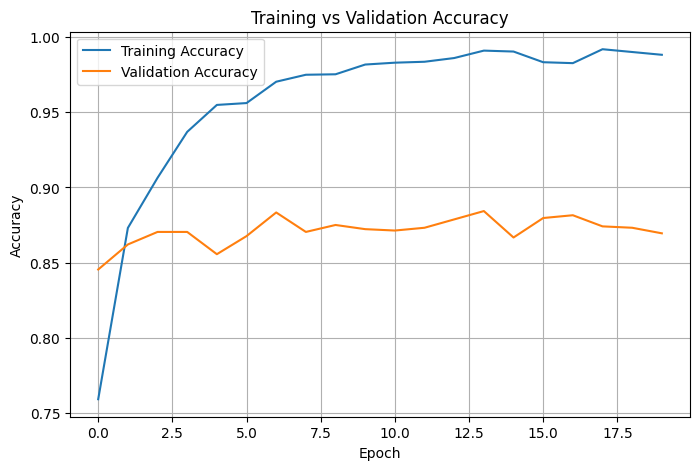

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize = (8,5))
plt.plot(history.history['accuracy'], label = 'Training Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


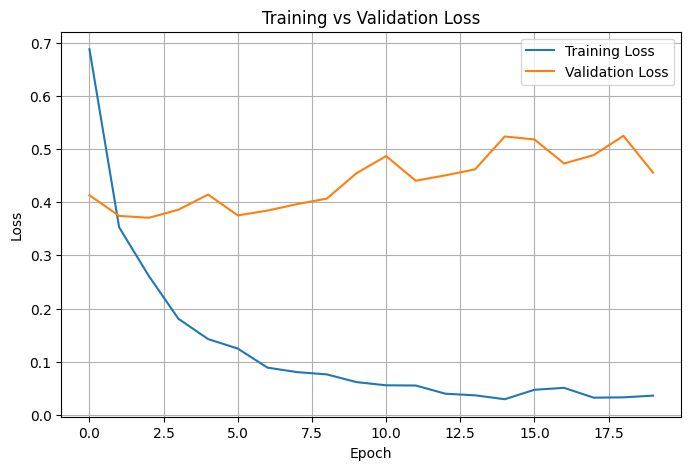

In [ ]:
# Plot loss
plt.figure(figsize = (8,5))
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


## **Implementing transfer learning in PyTorch**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np


Preparing the data

In [ ]:
# Normalization constants for ImageNet (used by ResNet)
mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)

# Convert and normalize
X_train_tensor = torch.tensor(X_train, dtype = torch.float32).permute(0, 3, 1, 2)
X_test_tensor = torch.tensor(X_test, dtype = torch.float32).permute(0, 3, 1, 2)

X_train_tensor = (X_train_tensor / 255.0 - mean) / std
X_test_tensor = (X_test_tensor / 255.0 - mean) / std

Y_train_tensor = torch.tensor(Y_train, dtype = torch.long)
Y_test_tensor = torch.tensor(Y_test, dtype = torch.long)

train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 32, shuffle = False)


### Model setup(ResNet50 + Custom classifer on top)

In [ ]:
resnet = models.resnet50(pretrained = True)
num_features = resnet.fc.in_features
resnet.fc = nn.Identity()

# Optional: unfreeze last 1–2 layers for fine-tuning
for name, param in resnet.named_parameters():
    if "layer4" in name:  # Last block
        param.requires_grad = True
    else:
        param.requires_grad = False

custom_classifier = nn.Sequential(
    nn.Linear(num_features, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, 5)  # 5 flower classes, raw logits
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet.to(device)
custom_classifier.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Linear(in_features=2048, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.3, inplace=False)
  (3): Linear(in_features=256, out_features=5, bias=True)
)

Defining loss function and optimizer

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(custom_classifier.parameters(), lr = 0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 7, gamma = 0.1)
epochs = 30


### Training loop

In [ ]:
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(epochs):
    resnet.eval()
    custom_classifier.train()
    running_loss, running_corrects = 0.0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        features = resnet(inputs)
        outputs = custom_classifier(features)

        if labels.ndim > 1:  # in case labels are one-hot
            labels = torch.argmax(labels, dim = 1)

        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        loss.backward()
        optimizer.step()

        running_loss + = loss.item() * inputs.size(0)
        running_corrects + = torch.sum(preds =  = labels)

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc.item())

    # Validation
    resnet.eval()
    custom_classifier.eval()
    val_loss, val_corrects = 0.0, 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            if labels.ndim > 1:
                labels = torch.argmax(labels, dim = 1)
            features = resnet(inputs)
            outputs = custom_classifier(features)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            val_loss + = loss.item() * inputs.size(0)
            val_corrects + = torch.sum(preds =  = labels)

    val_epoch_loss = val_loss / len(test_dataset)
    val_epoch_acc = val_corrects.double() / len(test_dataset)
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_acc.item())

    scheduler.step()  # Adjust learning rate

    print(f"Epoch {epoch+1}/{epochs} = > "
          f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f} | "
          f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}")


Epoch 1/30 => Train Loss: 0.6925, Train Acc: 0.7343 | Val Loss: 0.4459, Val Acc: 0.8352
Epoch 2/30 => Train Loss: 0.4719, Train Acc: 0.8282 | Val Loss: 0.3887, Val Acc: 0.8685
Epoch 3/30 => Train Loss: 0.3964, Train Acc: 0.8567 | Val Loss: 0.4068, Val Acc: 0.8472
Epoch 4/30 => Train Loss: 0.3460, Train Acc: 0.8736 | Val Loss: 0.4001, Val Acc: 0.8519
Epoch 5/30 => Train Loss: 0.3284, Train Acc: 0.8767 | Val Loss: 0.3741, Val Acc: 0.8546
Epoch 6/30 => Train Loss: 0.2974, Train Acc: 0.8919 | Val Loss: 0.3665, Val Acc: 0.8731
Epoch 7/30 => Train Loss: 0.2683, Train Acc: 0.9033 | Val Loss: 0.4242, Val Acc: 0.8583
Epoch 8/30 => Train Loss: 0.2049, Train Acc: 0.9271 | Val Loss: 0.3697, Val Acc: 0.8713
Epoch 9/30 => Train Loss: 0.1793, Train Acc: 0.9367 | Val Loss: 0.3696, Val Acc: 0.8741
Epoch 10/30 => Train Loss: 0.1723, Train Acc: 0.9438 | Val Loss: 0.3772, Val Acc: 0.8704
Epoch 11/30 => Train Loss: 0.1631, Train Acc: 0.9487 | Val Loss: 0.3664, Val Acc: 0.8769
Epoch 12/30 => Train Loss: 0.1

In [ ]:
final_val_acc = val_accuracies[-1] * 100
print(f"Final Validation Accuracy: {final_val_acc:.2f}%")


Final Validation Accuracy: 87.69%


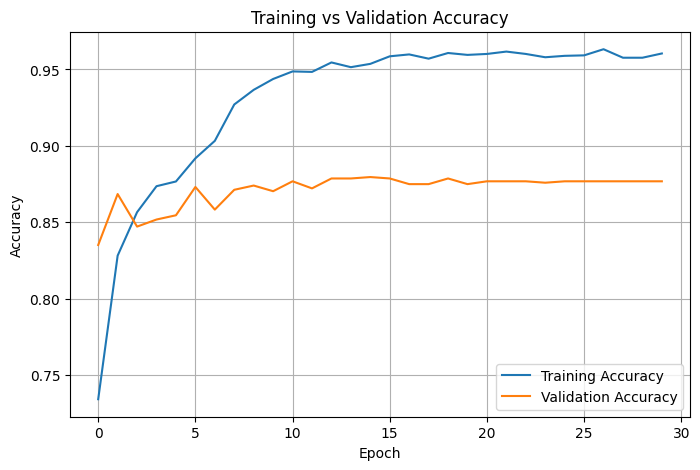

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize = (8, 5))
plt.plot(train_accuracies, label = 'Training Accuracy')
plt.plot(val_accuracies, label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()


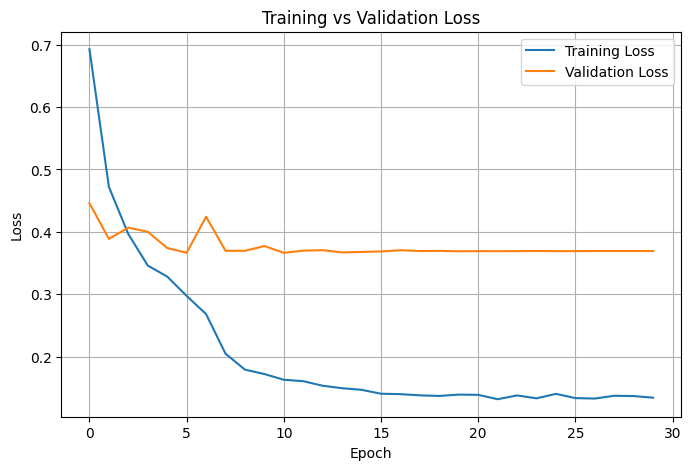

In [ ]:
plt.figure(figsize = (8, 5))
plt.plot(train_losses, label = 'Training Loss')
plt.plot(val_losses, label = 'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


### Fine tuning ResNet50

In [ ]:
for name, param in resnet.named_parameters():
    if "layer3" in name or "layer4" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

custom_classifier = nn.Sequential(
    nn.Linear(num_features, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(128, 5)  # 5 flower classes
)


***How do we know how many layers there are, and what layers we're talking about?***

In PyTorch, the term “layer” can mean different things depending on context. In our model, we are using a pretrained ResNet50 as the feature extractor and then adding a custom classifier using nn.Sequential.

The part of the code that defines the layers is the nn.Sequential block, where we manually stack the layers one after the other. Each line inside that block corresponds to one layer added to the model. The order in which they appear determines the numbering:

The first line creates a Linear layer to map the ResNet output features to 256 units — this is Layer 1.

The second line adds a ReLU activation — this is Layer 2.

The third line adds a Dropout layer to reduce overfitting — this is Layer 3.

The fourth line adds another Linear layer to output 5 class probabilities — this is Layer 4.

Since each of these components is explicitly written in the nn.Sequential, we can count them and identify which is which based on position. So, when we refer to "Layer 3" and "Layer 4", we are specifically referring to the Dropout and the final Linear classification layer in the custom classifier head.

Although ResNet50 itself has many more layers internally (like conv layers, batch norms, etc.), those are part of the pretrained base model. When we talk about Layer 3 and Layer 4 in this context, we’re only referring to the layers we added in the custom head.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet.to(device)
custom_classifier.to(device)


Sequential(
  (0): Linear(in_features=2048, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.3, inplace=False)
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.2, inplace=False)
  (6): Linear(in_features=128, out_features=5, bias=True)
)

In [ ]:
# 🔹 Loss, optimizer, and scheduler
criterion = nn.CrossEntropyLoss(label_smoothing = 0.1)
optimizer = optim.Adam(custom_classifier.parameters(), lr = 0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', factor = 0.5, patience = 3)


In [ ]:
# 🔹 Loss, optimizer, and scheduler
criterion = nn.CrossEntropyLoss(label_smoothing = 0.1)
optimizer = optim.Adam(custom_classifier.parameters(), lr = 0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', factor = 0.5, patience = 3)

In [ ]:
epochs = 50
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

In [ ]:
# 🔹 Training and validation loop
for epoch in range(epochs):
    resnet.eval()
    custom_classifier.train()
    running_loss, running_corrects = 0.0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        if labels.ndim > 1:
            labels = torch.argmax(labels, dim = 1)

        optimizer.zero_grad()
        features = resnet(inputs)
        outputs = custom_classifier(features)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        loss.backward()
        optimizer.step()

        running_loss + = loss.item() * inputs.size(0)
        running_corrects + = torch.sum(preds =  = labels)

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc.item())

    # 🔹 Validation
    resnet.eval()
    custom_classifier.eval()
    val_loss, val_corrects = 0.0, 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            if labels.ndim > 1:
                labels = torch.argmax(labels, dim = 1)
            features = resnet(inputs)
            outputs = custom_classifier(features)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            val_loss + = loss.item() * inputs.size(0)
            val_corrects + = torch.sum(preds =  = labels)

    val_epoch_loss = val_loss / len(test_dataset)
    val_epoch_acc = val_corrects.double() / len(test_dataset)
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_acc.item())

    scheduler.step(val_epoch_loss)

    print(f"Epoch {epoch+1}/{epochs} = > "
          f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f} | "
          f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}")

Epoch 1/50 => Train Loss: 0.9700, Train Acc: 0.7112 | Val Loss: 0.7673, Val Acc: 0.8231
Epoch 2/50 => Train Loss: 0.7745, Train Acc: 0.8211 | Val Loss: 0.7564, Val Acc: 0.8222
Epoch 3/50 => Train Loss: 0.7214, Train Acc: 0.8551 | Val Loss: 0.7068, Val Acc: 0.8491
Epoch 4/50 => Train Loss: 0.6920, Train Acc: 0.8653 | Val Loss: 0.6783, Val Acc: 0.8713
Epoch 5/50 => Train Loss: 0.6702, Train Acc: 0.8758 | Val Loss: 0.6780, Val Acc: 0.8639
Epoch 6/50 => Train Loss: 0.6576, Train Acc: 0.8851 | Val Loss: 0.6975, Val Acc: 0.8491
Epoch 7/50 => Train Loss: 0.6414, Train Acc: 0.8974 | Val Loss: 0.6808, Val Acc: 0.8620
Epoch 8/50 => Train Loss: 0.6214, Train Acc: 0.9058 | Val Loss: 0.6860, Val Acc: 0.8583
Epoch 9/50 => Train Loss: 0.6024, Train Acc: 0.9206 | Val Loss: 0.7227, Val Acc: 0.8407
Epoch 10/50 => Train Loss: 0.5681, Train Acc: 0.9385 | Val Loss: 0.6713, Val Acc: 0.8722
Epoch 11/50 => Train Loss: 0.5558, Train Acc: 0.9453 | Val Loss: 0.6936, Val Acc: 0.8537
Epoch 12/50 => Train Loss: 0.5

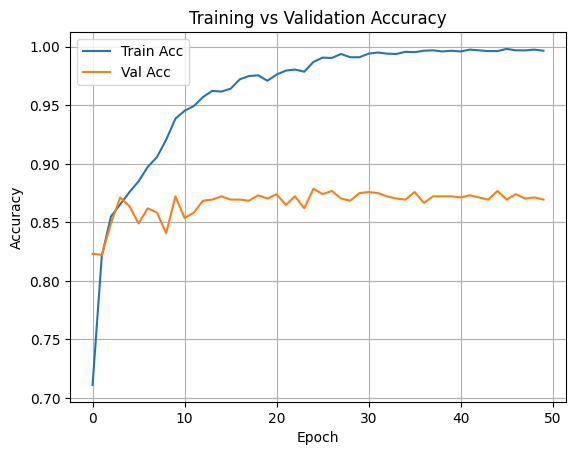

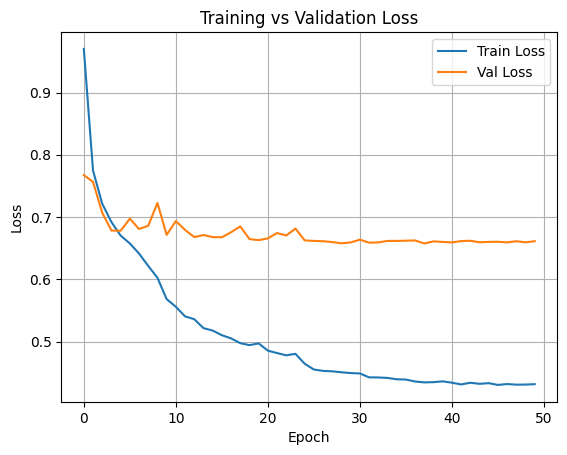

In [ ]:
# Accuracy plot
plt.plot(train_accuracies, label = 'Train Acc')
plt.plot(val_accuracies, label = 'Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss plot
plt.plot(train_losses, label = 'Train Loss')
plt.plot(val_losses, label = 'Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


EffiecientNet-B0

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random



In [ ]:
# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_names = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [ ]:
X_train_tensor = torch.tensor(X_train, dtype = torch.float32).permute(0, 3, 1, 2)
X_test_tensor = torch.tensor(X_test, dtype = torch.float32).permute(0, 3, 1, 2)
X_train_tensor = (X_train_tensor / 255.0 - mean) / std
X_test_tensor = (X_test_tensor / 255.0 - mean) / std

Y_train_tensor = torch.tensor(Y_train, dtype = torch.long)
Y_test_tensor = torch.tensor(Y_test, dtype = torch.long)

train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 32)

### Loading EfficientNet-B0

In [ ]:
# Load EfficientNet-B0
efficientnet = models.efficientnet_b0(pretrained = True)
in_features = efficientnet.classifier[1].in_features
efficientnet.classifier[1] = nn.Linear(in_features, 5)  # 5 flower classes
efficientnet.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 127MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
# Loss, Optimizer, Scheduler
criterion = nn.CrossEntropyLoss(label_smoothing = 0.1)
optimizer = optim.Adam(efficientnet.parameters(), lr = 0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', factor = 0.5, patience = 3)

In [ ]:
# Training Loop
epochs = 30
train_accuracies, val_accuracies = [], []

for epoch in range(epochs):
    efficientnet.train()
    correct, total = 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        if labels.ndim > 1:
            labels = torch.argmax(labels, dim = 1)

        optimizer.zero_grad()
        outputs = efficientnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        correct + = torch.sum(preds =  = labels)
        total + = labels.size(0)

    train_acc = correct.double() / total
    train_accuracies.append(train_acc.item())

    # Validation
    efficientnet.eval()
    correct, total = 0, 0
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            if labels.ndim > 1:
                labels = torch.argmax(labels, dim = 1)
            outputs = efficientnet(inputs)
            loss = criterion(outputs, labels)
            val_loss + = loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct + = torch.sum(preds =  = labels)
            total + = labels.size(0)

    val_acc = correct.double() / total
    val_accuracies.append(val_acc.item())
    scheduler.step(val_loss / len(test_dataset))

    print(f"Epoch {epoch+1}/{epochs} = > Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")


Epoch 1/30 => Train Acc: 0.7986 | Val Acc: 0.8657
Epoch 2/30 => Train Acc: 0.9092 | Val Acc: 0.9083
Epoch 3/30 => Train Acc: 0.9379 | Val Acc: 0.9074
Epoch 4/30 => Train Acc: 0.9571 | Val Acc: 0.8963
Epoch 5/30 => Train Acc: 0.9592 | Val Acc: 0.9148
Epoch 6/30 => Train Acc: 0.9697 | Val Acc: 0.9046
Epoch 7/30 => Train Acc: 0.9568 | Val Acc: 0.9083
Epoch 8/30 => Train Acc: 0.9787 | Val Acc: 0.9194
Epoch 9/30 => Train Acc: 0.9917 | Val Acc: 0.9130
Epoch 10/30 => Train Acc: 0.9932 | Val Acc: 0.9231
Epoch 11/30 => Train Acc: 0.9985 | Val Acc: 0.9296
Epoch 12/30 => Train Acc: 0.9947 | Val Acc: 0.9306
Epoch 13/30 => Train Acc: 0.9954 | Val Acc: 0.9130
Epoch 14/30 => Train Acc: 0.9969 | Val Acc: 0.9296
Epoch 15/30 => Train Acc: 0.9972 | Val Acc: 0.9278
Epoch 16/30 => Train Acc: 0.9969 | Val Acc: 0.9269
Epoch 17/30 => Train Acc: 0.9960 | Val Acc: 0.9278
Epoch 18/30 => Train Acc: 0.9991 | Val Acc: 0.9324
Epoch 19/30 => Train Acc: 0.9988 | Val Acc: 0.9287
Epoch 20/30 => Train Acc: 0.9978 | Val A

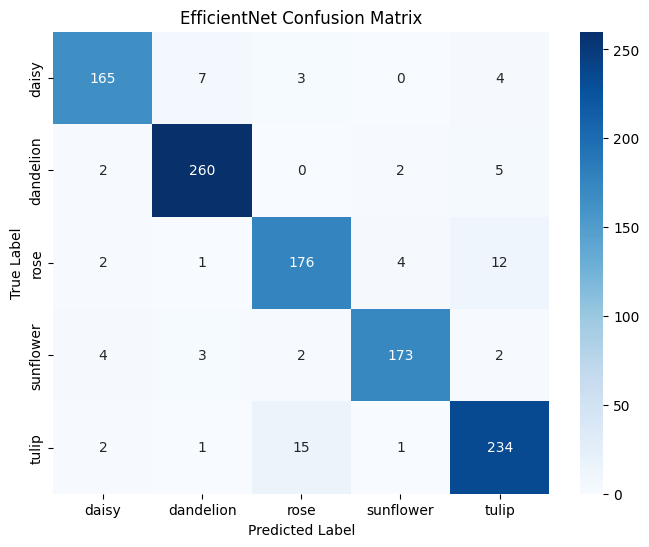

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate model on test set
efficientnet.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        if labels.ndim > 1:
            labels = torch.argmax(labels, dim = 1)
        outputs = efficientnet(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
class_names = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

plt.figure(figsize = (8, 6))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues',
            xticklabels = class_names,
            yticklabels = class_names)
plt.title("EfficientNet Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [ ]:
final_val_acc = val_accuracies[-1] * 100
print(f"Final Validation Accuracy: {final_val_acc:.2f}%")


Final Validation Accuracy: 93.33%


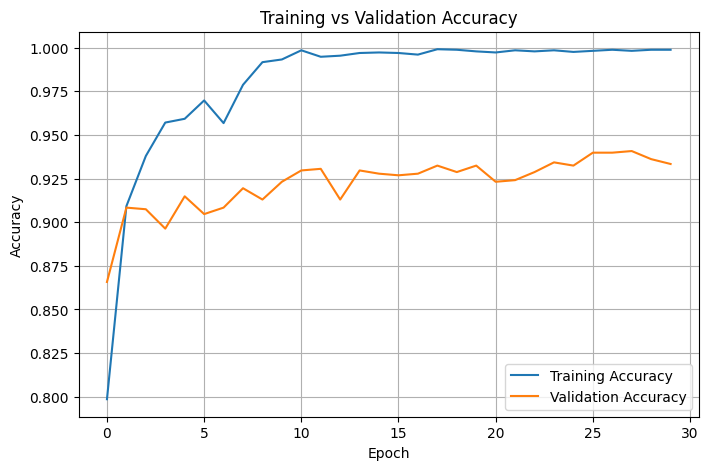

In [ ]:
plt.figure(figsize = (8, 5))
plt.plot(train_accuracies, label = 'Training Accuracy')
plt.plot(val_accuracies, label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()


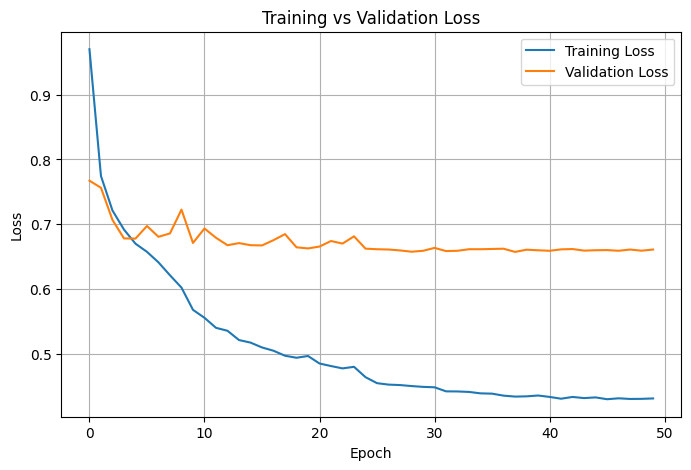

In [ ]:
plt.figure(figsize = (8, 5))
plt.plot(train_losses, label = 'Training Loss')
plt.plot(val_losses, label = 'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()
